**Задание**
* Используя данные из обучающего датасета **housing.csv**, получить обучающий и тестовый наборы , построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета.

* Целевая переменная:
Price

* Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)
* https://github.com/ageron/handson-ml2/tree/master/datasets/housing
* https://www.kaggle.com/harrywang/housing?select=housing.csv


### Подключение и настройка библиотек и скриптов

In [48]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize'] = (6, 4)
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 50)

### Вспомогательные функции

In [33]:
def reduce_mem_usage(df):   # Уменьшить размер датасета
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def evaluate_preds(true_values, pred_values, save=False):   # Оценка качества модели и график preds vs true
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

def show_target_distplot():  # график распределения целевой переменной
  target_mean = round(df['median_house_value'].mean(), 2)
  target_median = df['median_house_value'].median()
  target_mode = df['median_house_value'].mode()[0]
  plt.figure(figsize = (16, 8))

  sns.distplot(df['median_house_value'], bins=50)

  y = np.linspace(0, 0.000005, 10)
  plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
  plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
  plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)
  plt.title('Distribution of median_house_value')
  plt.legend()
  plt.show()

def get_condition(df, column): # отобрать выбросы 
  max_value = np.quantile(df[column], q=0.975)
  min_value = np.quantile(df[column], q=0.025)
  condition = (df[column] > max_value) | (df[column] < min_value)
  return condition

### Загрузка данных

**Пути к директориям и файлам**

In [49]:
from google.colab import drive
drive.mount('/content/gdrive')  # монтируем Google-Drive

DATASET_PATH = 'gdrive/My Drive/Colab Notebooks/housing.csv'
PREPARED_DATASET_PATH = 'gdrive/My Drive/Colab Notebooks/housing_prepared.csv'
SCALER_FILE_PATH = 'gdrive/My Drive/Colab Notebooks/housing_scaler.pkl'
MODEL_FILE_PATH = 'gdrive/My Drive/Colab Notebooks/housing_model.pkl' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома  **(target)**

Считываем данные. По строкам - наблюдения, по столбцам - признаки.



In [50]:
df = pd.read_csv(DATASET_PATH, sep=',')
df = reduce_mem_usage(df)  # уменьшим развер DS
df.head()

Memory usage of dataframe is 1.73 MB
Memory usage after optimization is: 0.77 MB
Decreased by 55.7%


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY,0
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY,1
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY,2
3,-122.25,37.85,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,NEAR BAY,3
4,-122.25,37.85,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,NEAR BAY,4


In [51]:
df.shape

(20640, 11)

### Общая информации о данных

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float32 
 1   latitude            20640 non-null  float32 
 2   housing_median_age  19918 non-null  float32 
 3   total_rooms         20640 non-null  float32 
 4   total_bedrooms      20433 non-null  float32 
 5   population          20041 non-null  float32 
 6   households          20640 non-null  float32 
 7   median_income       20640 non-null  float32 
 8   median_house_value  20640 non-null  float32 
 9   ocean_proximity     20640 non-null  category
 10  id                  20640 non-null  int16   
dtypes: category(1), float32(9), int16(1)
memory usage: 786.4 KB


In [53]:
df.describe().T  # распределение

,count,mean,std,min,25%,50%,75%,max
longitude,20640.00,-119.47,5.04,-124.35,-121.80,-118.49,-118.01,122.03
latitude,20640.00,35.04,94.90,-13534.03,33.93,34.26,37.71,1327.13
housing_median_age,19918.00,28.65,12.58,1.00,18.00,29.00,37.00,52.00
total_rooms,20640.00,2635.76,2181.60,2.00,1447.75,2127.00,3148.00,39320.00
total_bedrooms,20433.00,537.87,421.38,1.00,296.00,435.00,647.00,6445.00
population,20041.00,1425.42,1135.19,3.00,786.00,1165.00,1726.00,35682.00
households,20640.00,499.54,382.33,1.00,280.00,409.00,605.00,6082.00
median_income,20640.00,3.87,1.90,0.50,2.56,3.53,4.74,15.00
median_house_value,20640.00,206854.97,115395.19,14999.00,119600.00,179700.00,264725.00,500001.00
id,20640.00,10319.50,5958.40,0.00,5159.75,10319.50,15479.25,20639.00


**Распределение целевой переменной**

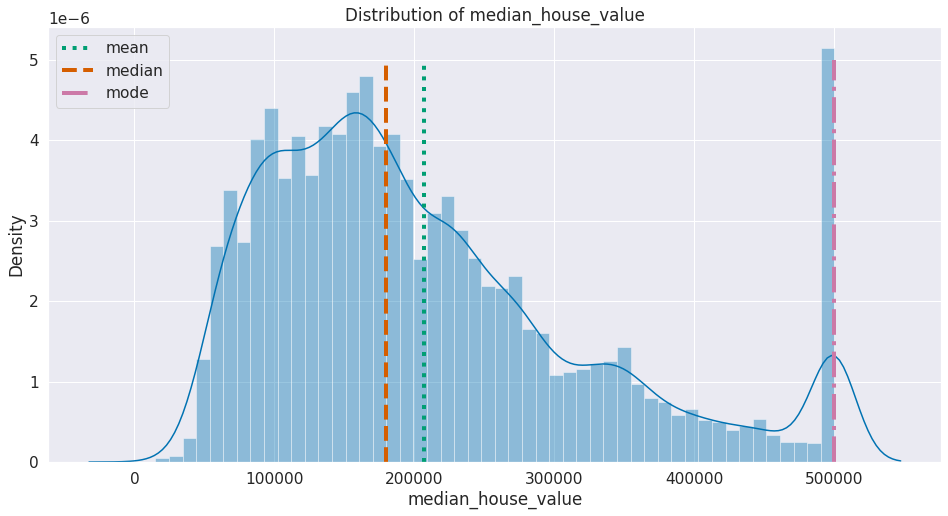

In [54]:
show_target_distplot()

Из графика можно увидеть:
* несимметричное распределение целевой переменной;
* странный выброс целевой переменной 500000 с масимальной частотой
* количество строк незначительно

Удалим этот выброс и перестоим график


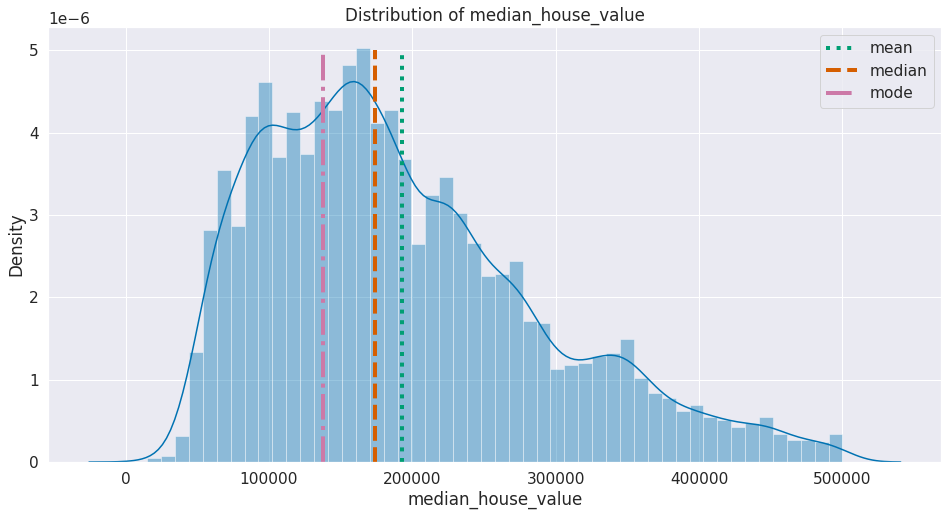

In [55]:
df = df[df['median_house_value'] <= 500000].reset_index()
show_target_distplot()

**Построение нового признака population_per_room и анализ записей DS**

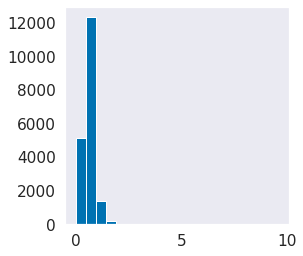

In [56]:
df['population_per_room'] = round(df['population'] / df['total_rooms'], 1)
df.loc[df['population_per_room'] < 10, 'population_per_room'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [57]:
df[df['population_per_room'] > 2.5] [['total_rooms', 'population', 'population_per_room']]
   

,total_rooms,population,population_per_room
90,215.00,904.00,4.20
269,142.00,575.00,4.00
458,1087.00,3337.00,3.10
1027,1748.00,4930.00,2.80
2871,120.00,477.00,4.00
3098,2.00,6.00,3.00
3336,36.00,4198.00,116.60
4384,247.00,925.00,3.70
4491,350.00,1122.00,3.20
5744,555.00,1492.00,2.70


In [58]:
df = df[df['population_per_room'] <= 5].reset_index() # отбросим записи, в которых людей в комнате > 5 

**Категориальные переменные**

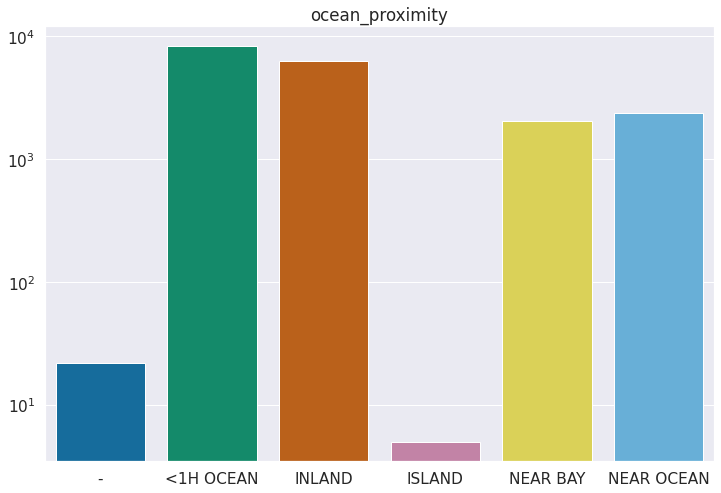

In [59]:
counts = df['ocean_proximity'].value_counts()
    
plt.figure(figsize=(12,8))    
plt.title('ocean_proximity')
sns.barplot(counts.index, counts.values, log=True)
    
plt.show()

**Преобразуем категориальные признаки в бинарные**

In [60]:
df.replace(
    {'ocean_proximity':
     {'-': df['ocean_proximity'].mode()[0]}
    },
    inplace=True)
df = pd.concat([df, pd.get_dummies(df['ocean_proximity'])], axis=1)
df.head()

,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY,0,0.40,0,0,0,1,0
1,1,1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY,1,0.30,0,0,0,1,0
2,2,2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY,2,0.30,0,0,0,1,0
3,3,3,-122.25,37.85,52.00,1274.00,235.00,558.00,219.00,5.64,341300.00,NEAR BAY,3,0.40,0,0,0,1,0
4,4,4,-122.25,37.85,52.00,1627.00,280.00,565.00,259.00,3.85,342200.00,NEAR BAY,4,0.30,0,0,0,1,0


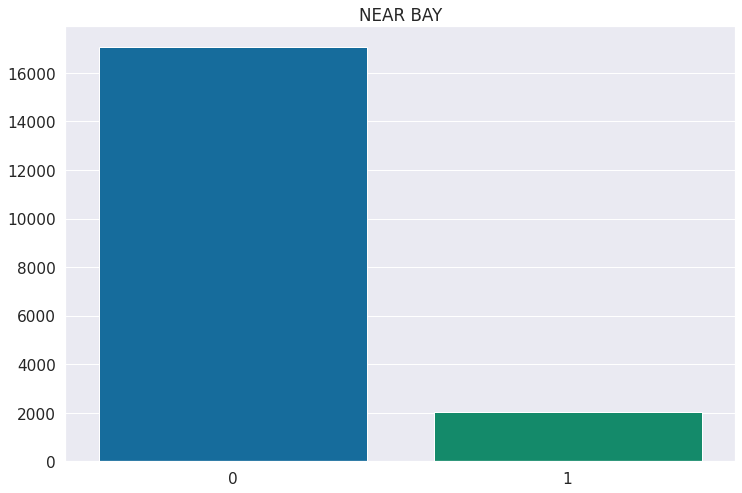

In [61]:
counts = df['NEAR BAY'].value_counts()
    
plt.figure(figsize=(12,8))    
plt.title('NEAR BAY')
sns.barplot(counts.index, counts.values)
    
plt.show()

**Количественные переменные**

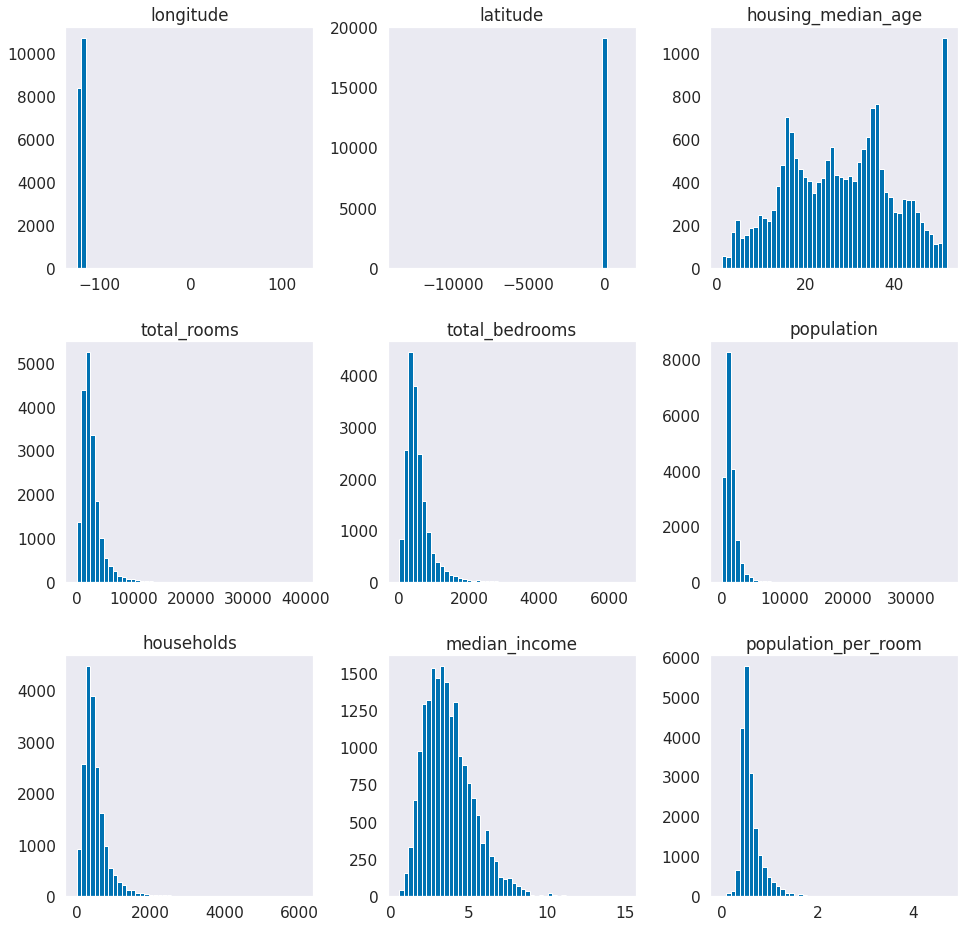

In [62]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('median_house_value', axis=1, inplace=True)
df_num_features.hist(figsize=(16,16), bins=50, grid=False);

### Обработка пропусков




In [63]:
df.isna().sum()

level_0                  0
index                    0
longitude                0
latitude                 0
housing_median_age     656
total_rooms              0
total_bedrooms         192
population               0
households               0
median_income            0
median_house_value       0
ocean_proximity          0
id                       0
population_per_room      0
<1H OCEAN                0
INLAND                   0
ISLAND                   0
NEAR BAY                 0
NEAR OCEAN               0
dtype: int64

**housing_median_age**

In [64]:
df['housing_median_age'].value_counts()

52.00    1034
36.00     764
35.00     745
16.00     704
17.00     636
         ... 
49.00     113
3.00       54
2.00       51
51.00      39
1.00        4
Name: housing_median_age, Length: 52, dtype: int64

In [65]:
df['housing_median_age'].fillna(df['housing_median_age'].median(), inplace=True)

**total_bedrooms**

In [66]:
df['total_bedrooms'].value_counts()

280.00     50
331.00     47
393.00     47
348.00     47
394.00     46
           ..
1033.00     1
2208.00     1
2576.00     1
1702.00     1
2062.00     1
Name: total_bedrooms, Length: 1890, dtype: int64

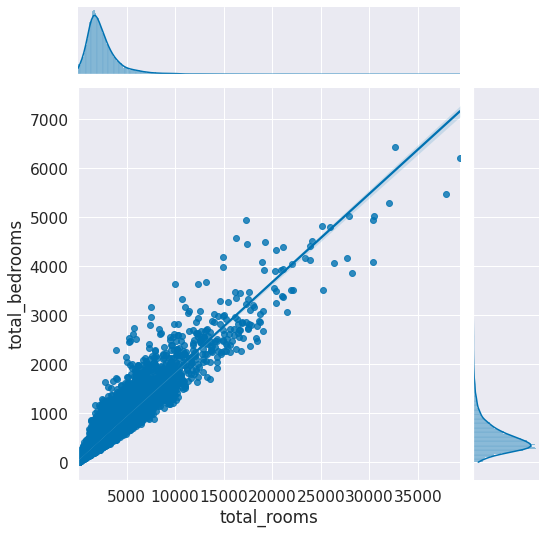

In [67]:
grid = sns.jointplot(df['total_rooms'], df['total_bedrooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

In [68]:
avg_bedrooms_on_avg_rooms = df['total_bedrooms'].mean()/df['total_rooms'].mean()
print(f'Среднее число спален на комнату {avg_bedrooms_on_avg_rooms}')
df.loc[df['total_bedrooms'].isna(), 'total_bedrooms'] = avg_bedrooms_on_avg_rooms * df['total_rooms']

Среднее число спален на комнату 0.20599035604336083


In [69]:
df.isna().sum()

level_0                0
index                  0
longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms         0
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        0
id                     0
population_per_room    0
<1H OCEAN              0
INLAND                 0
ISLAND                 0
NEAR BAY               0
NEAR OCEAN             0
dtype: int64

In [ ]:
#Компактный вариант с медианой
"""
medians = df[['housing_median_age', 'total_bedrooms', 'population']].median()
print(medians)
df[['housing_median_age', 'total_bedrooms', 'population']] = \
        df[['housing_median_age', 'total_bedrooms', 'population']].fillna(medians)
"""

### Обработка выбросов

In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
level_0,19088.00,9840.60,5676.94,0.00,4926.75,9854.50,14750.25,19674.00
index,19088.00,10288.78,5983.59,0.00,5048.75,10341.50,15382.25,20639.00
longitude,19088.00,-119.47,4.92,-124.35,-121.77,-118.50,-117.99,122.03
latitude,19088.00,35.01,98.68,-13534.03,33.93,34.27,37.73,1327.13
housing_median_age,19088.00,28.35,12.28,1.00,18.00,28.00,36.00,52.00
total_rooms,19088.00,2621.51,2182.55,2.00,1439.75,2112.00,3121.25,39320.00
total_bedrooms,19088.00,539.81,422.08,2.00,297.00,436.00,648.00,6445.00
population,19088.00,1439.38,1143.07,3.00,795.00,1177.00,1747.00,35682.00
households,19088.00,501.44,382.94,2.00,282.00,411.00,606.00,6082.00
median_income,19088.00,3.68,1.57,0.50,2.53,3.45,4.58,15.00


**longitude,  latitude**


Калифорния
Соединённые Штаты Америки
Координаты:
38.561785, -121.449756


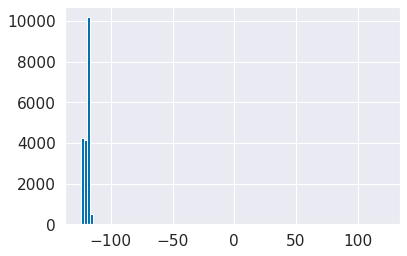

In [71]:
df['longitude'].hist(bins=100);
#plt.scatter(df['latitude'], df['longitude'])

In [72]:
df[df['longitude'] >= 0]

,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
3354,3451,3479,118.51,34.29,29.00,1287.00,194.00,525.00,187.00,6.42,319300.00,<1H OCEAN,3479,0.40,1,0,0,0,0
5481,5663,5904,118.43,34.29,39.00,1769.00,410.00,1499.00,390.00,3.12,153500.00,<1H OCEAN,5904,0.80,1,0,0,0,0
7835,8097,8405,118.36,33.93,40.00,1625.00,500.00,2036.00,476.00,2.63,156500.00,<1H OCEAN,8405,1.30,1,0,0,0,0
12084,12463,13051,121.29,38.61,17.00,13553.00,2474.00,6544.00,2359.00,3.97,132700.00,INLAND,13051,0.50,0,1,0,0,0
14201,14634,15263,117.27,33.02,21.00,2144.00,340.00,928.00,344.00,5.80,286100.00,NEAR OCEAN,15263,0.40,0,0,0,0,1
15841,16322,17085,0.00,37.47,33.00,1266.00,415.00,1991.00,334.00,2.92,202800.00,NEAR OCEAN,17085,1.60,0,0,0,0,1
16044,16532,17359,0.00,34.88,4.00,3680.00,559.00,1678.00,569.00,5.06,201700.00,<1H OCEAN,17359,0.50,1,0,0,0,0
17085,17605,18551,122.03,36.96,28.00,1607.00,421.00,926.00,385.00,2.42,216100.00,NEAR OCEAN,18551,0.60,0,0,0,0,1
17933,18476,19423,0.00,37.69,5.00,9601.00,1639.00,4449.00,1575.00,4.53,195500.00,INLAND,19423,0.50,0,1,0,0,0


In [73]:
df.loc[df['longitude'] > 0, 'longitude'] = df.loc[df['longitude'] > 0, 'longitude'] * -1

In [74]:
df[df['longitude'] == 0]

,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
15841,16322,17085,0.00,37.47,33.00,1266.00,415.00,1991.00,334.00,2.92,202800.00,NEAR OCEAN,17085,1.60,0,0,0,0,1
16044,16532,17359,0.00,34.88,4.00,3680.00,559.00,1678.00,569.00,5.06,201700.00,<1H OCEAN,17359,0.50,1,0,0,0,0
17933,18476,19423,0.00,37.69,5.00,9601.00,1639.00,4449.00,1575.00,4.53,195500.00,INLAND,19423,0.50,0,1,0,0,0


In [76]:
df.loc[df['longitude'] == 0, 'longitude'] = df['longitude'].median()

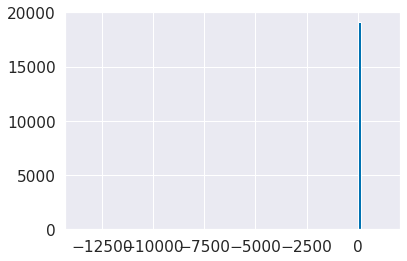

In [75]:
df['latitude'].hist(bins=100);

In [77]:
df[(df['latitude'] <= 0) | (df['latitude'] > 50)]

,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
7726,7981,8283,-118.13,-13534.03,45.00,1016.00,172.00,361.00,163.00,7.50,434500.00,NEAR OCEAN,8283,0.40,0,0,0,0,1
11814,12184,12772,-121.42,1327.13,28.00,2217.00,536.00,1203.00,507.00,1.94,73100.00,INLAND,12772,0.50,0,1,0,0,0


In [78]:
df.loc[(df['latitude'] <= 0) | (df['latitude'] > 50), 'latitude'] = df['latitude'].median()

**housing_median_age**

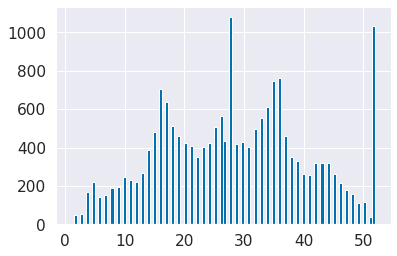

In [79]:
df['housing_median_age'].hist(bins=100);


In [80]:
df['housing_median_age'].value_counts()

28.00    1079
52.00    1034
36.00     764
35.00     745
16.00     704
         ... 
49.00     113
3.00       54
2.00       51
51.00      39
1.00        4
Name: housing_median_age, Length: 52, dtype: int64

In [ ]:
# df.loc[(df['housing_median_age'] == 28) | (df['housing_median_age'] == 52), 'housing_median_age'] = df['housing_median_age'].mean()

Что делать с выбросами 28 и 52 ?
* Присвоение какого-либо значения не решает проблему.
* Механической ошибки быть не может, так как строк много.
* Удалять не стоит, так как это весомая часть датасета.
* Нужен анализ исторических данных, возможно были значительные инвестиции в стоительство.
* Решил оставить как есть.


**total_rooms**

In [81]:
df['total_rooms'].describe()

count   19088.00
mean     2621.51
std      2182.55
min         2.00
25%      1439.75
50%      2112.00
75%      3121.25
max     39320.00
Name: total_rooms, dtype: float64

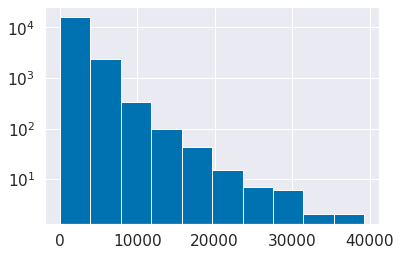

In [82]:
df['total_rooms'].hist(log=True);

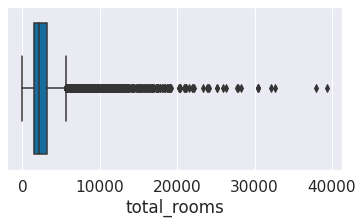

In [83]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['total_rooms'], whis=1.5)
plt.xlabel('total_rooms')
plt.show()

Вряд ли в Калифорнии много сверхбольших жилых домов
* Оценка макс числа комнат в жилых домах  ~ 3000 *5 ~15000
* https://domdata.ru/doma-po-kvartiram

In [84]:
df.loc[df['total_rooms'] > 8000, 'total_rooms'] = df['total_rooms'].median()

**total_bedrooms**

In [85]:
df['total_bedrooms'].describe()

count   19088.00
mean      539.81
std       422.08
min         2.00
25%       297.00
50%       436.00
75%       648.00
max      6445.00
Name: total_bedrooms, dtype: float64

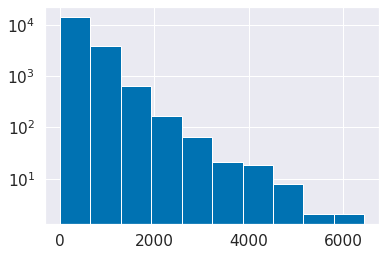

In [86]:
df['total_bedrooms'].hist(log=True);

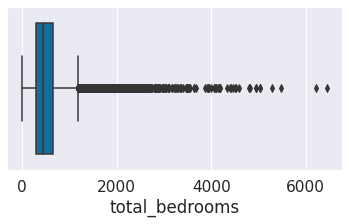

In [87]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['total_bedrooms'], whis=1.5)
plt.xlabel('total_bedrooms')
plt.show()

In [88]:
df.loc[df['total_bedrooms'] > 1600, 'total_bedrooms'] = df['total_bedrooms'].median()

**population**

In [89]:
df['population'].describe()

count   19088.00
mean     1439.38
std      1143.07
min         3.00
25%       795.00
50%      1177.00
75%      1747.00
max     35682.00
Name: population, dtype: float64

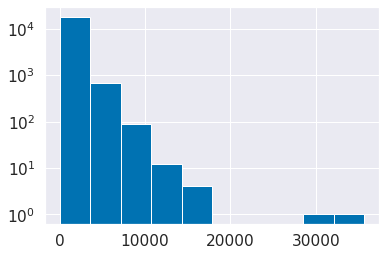

In [90]:
df['population'].hist(log=True);

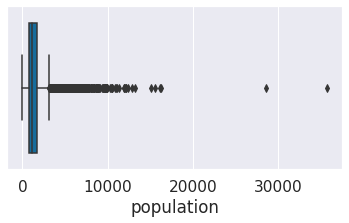

In [91]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['population'], whis=1.5)
plt.xlabel('population')
plt.show()

In [92]:
df.loc[df['population'] > 10000, 'population'] = df['population'].median()

**households**

In [93]:
df['households'].describe()

count   19088.00
mean      501.44
std       382.94
min         2.00
25%       282.00
50%       411.00
75%       606.00
max      6082.00
Name: households, dtype: float64

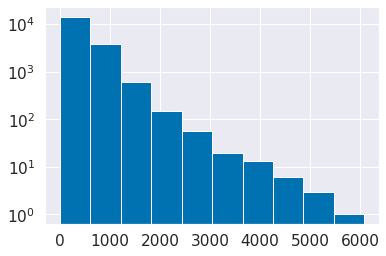

In [94]:
df['households'].hist(log=True);

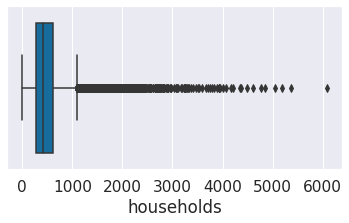

In [95]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['households'], whis=1.5)
plt.xlabel('households')
plt.show()

In [96]:
df.loc[df['households'] > 2000, 'households'] = df['households'].median()

**median_income**

In [97]:
df['median_income'].describe()

count   19088.00
mean        3.68
std         1.57
min         0.50
25%         2.53
50%         3.45
75%         4.58
max        15.00
Name: median_income, dtype: float64

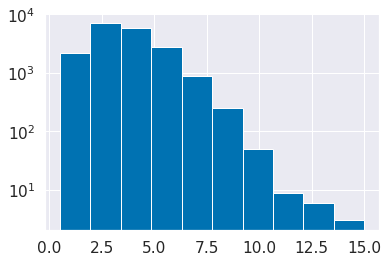

In [98]:
df['median_income'].hist(log=True);

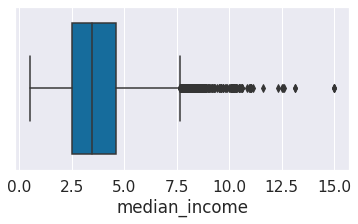

In [99]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['median_income'], whis=1.5)
plt.xlabel('median_income')
plt.show()

In [100]:
df.loc[df['median_income'] > 8, 'median_income'] = df['median_income'].median()

**Оставим признаки, которые необходимы для модели**


In [101]:
df.columns.tolist()

['level_0',
 'index',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'id',
 'population_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [102]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'
df = df[feature_names + [target_name]]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,3.45,0,0,1,0,452600.00
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,3.45,0,0,1,0,358500.00
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,0,0,1,0,352100.00
3,-122.25,37.85,52.00,1274.00,235.00,558.00,219.00,5.64,0,0,1,0,341300.00
4,-122.25,37.85,52.00,1627.00,280.00,565.00,259.00,3.85,0,0,1,0,342200.00


**Мультиколлениарность. Матрица корреляций**

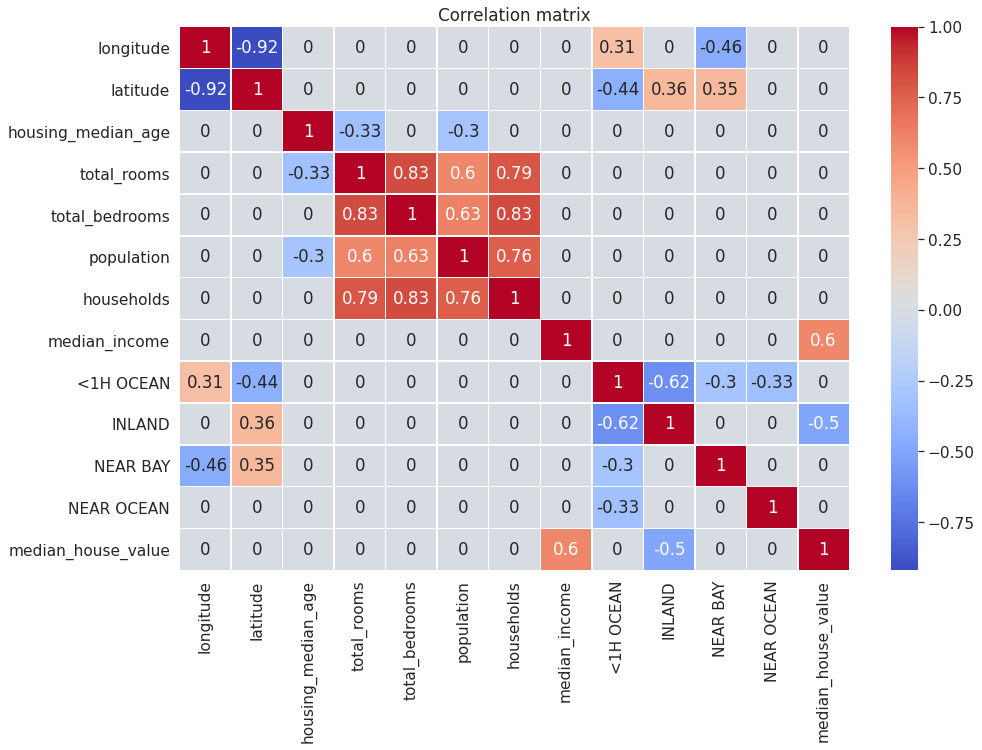

In [103]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Стандартизация признаков**

In [104]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-1.33,1.03,1.03,-1.07,-1.27,-1.06,-1.16,-0.11,0,0,1,0,452600.00
1,-1.32,1.03,-0.60,3.38,2.16,0.94,2.18,-0.11,0,0,1,0,358500.00
2,-1.33,1.02,1.93,-0.65,-1.06,-0.90,-1.00,2.53,0,0,1,0,352100.00
3,-1.34,1.02,1.93,-0.79,-0.90,-0.84,-0.86,1.41,0,0,1,0,341300.00
4,-1.34,1.02,1.93,-0.54,-0.74,-0.83,-0.72,0.17,0,0,1,0,342200.00


### Сохранение  датасета

In [105]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')

### Разбиение на train и test

In [106]:
X = df[feature_names]
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

### Построение базовых моделей и выбор лучшей

**Linear Regression**

R2:	0.544
RMSE:	65765.4
MSE:	4325087700.0


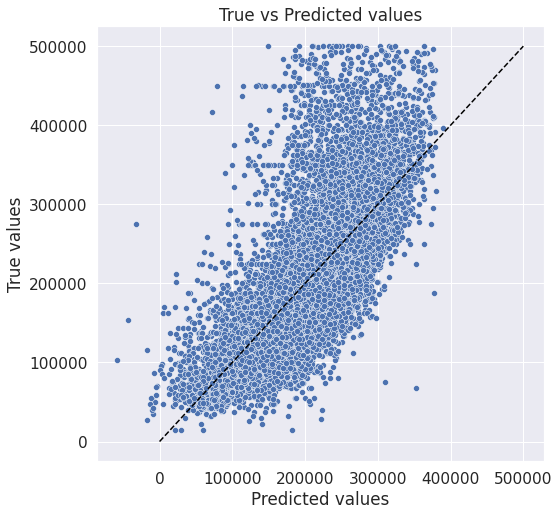

R2:	0.541
RMSE:	66603.09
MSE:	4435971600.0


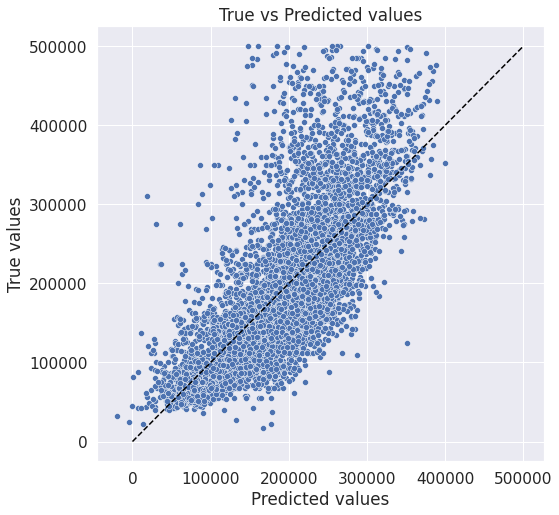

In [107]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Random Forest**

R2:	0.662
RMSE:	56606.408
MSE:	3204285370.813


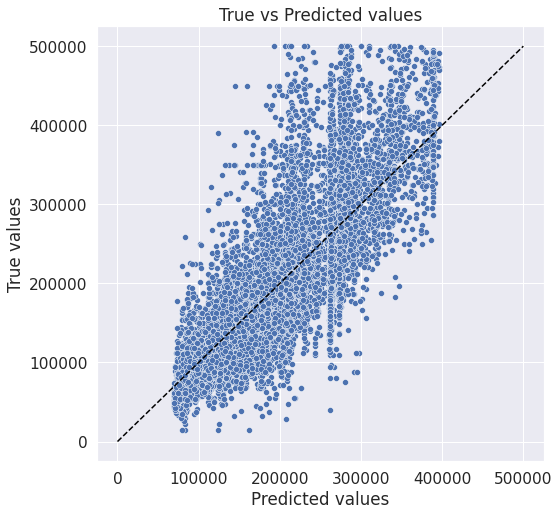

R2:	0.638
RMSE:	59201.224
MSE:	3504784891.317


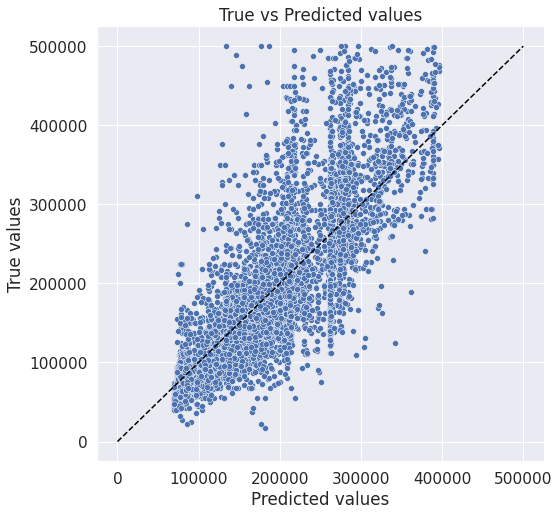

In [108]:
rf_model = RandomForestRegressor(max_depth=6)
rf_model.fit(X_train, y_train)
RandomForestRegressor(max_depth=6)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Gradient Boosting**


R2:	0.744
RMSE:	49284.896
MSE:	2429001021.984


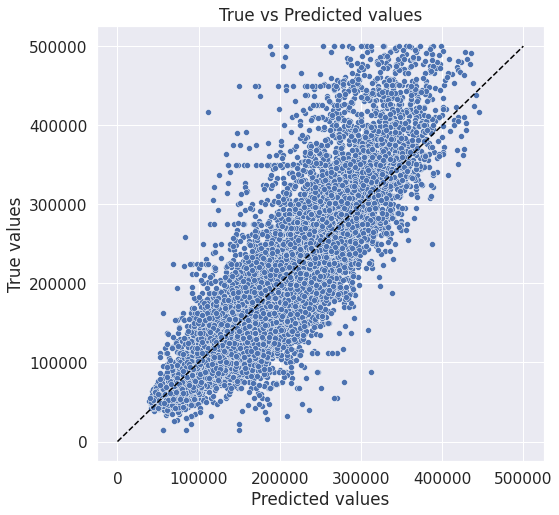

R2:	0.726
RMSE:	51444.452
MSE:	2646531618.203


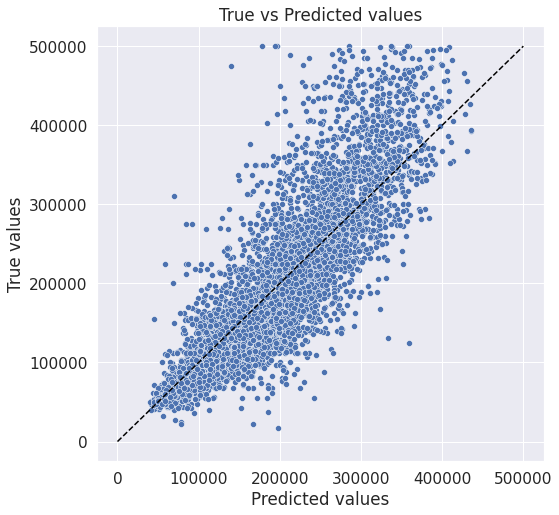

In [109]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
GradientBoostingRegressor()
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Настройка и оценка финальной модели

**Подбор гиперпараметров**

In [41]:
gb_model = GradientBoostingRegressor(random_state=21)
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 5, 'n_estimators': 400}
0.7942140694164087


{'max_depth': 5, 'n_estimators': 400}
0.7942140694164087

**Обучение и оценка финальной модели**

R2:	0.921
RMSE:	27309.136
MSE:	745788934.422


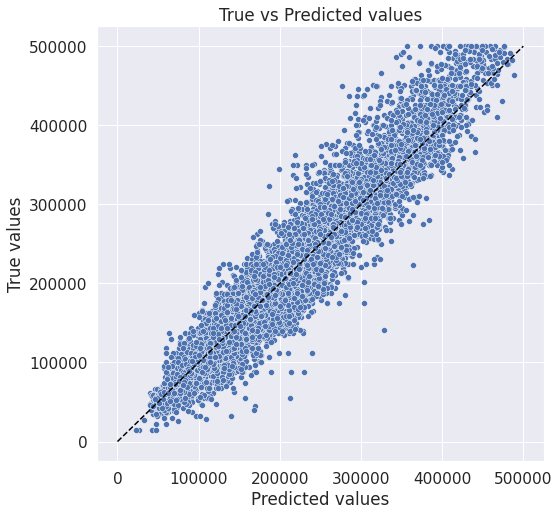

R2:	0.808
RMSE:	43145.129
MSE:	1861502159.159


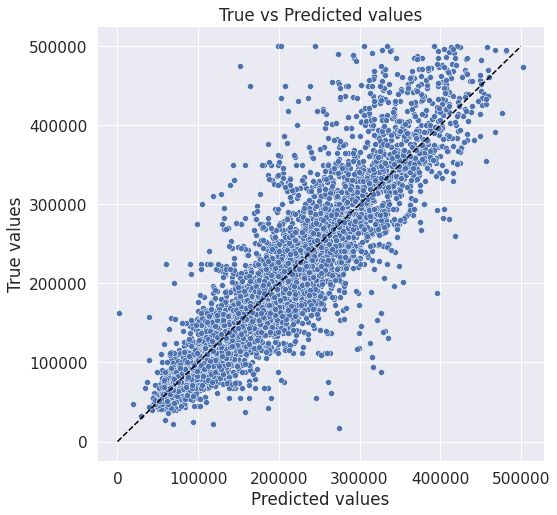

In [110]:
final_model = GradientBoostingRegressor(n_estimators=400, max_depth=5, random_state=42)
final_model.fit(X_train, y_train)
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Важность признаков**

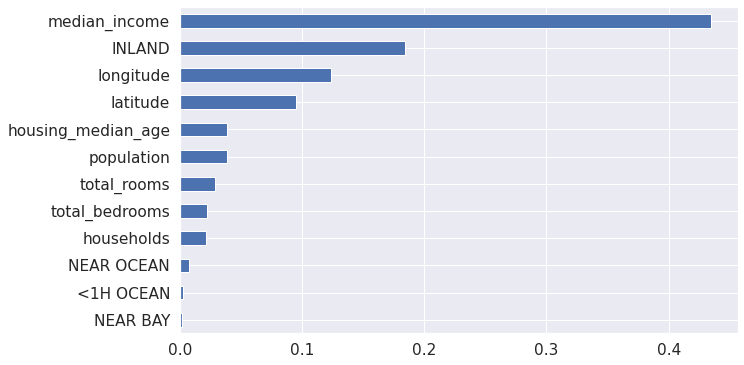

In [111]:
importances = final_model.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh', figsize=(10, 6));

### Сохранение модели

In [112]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)